In [16]:
# import necessary modules
# uncomment to get plots displayed in notebook
%matplotlib notebook
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from classy import Class
from scipy.optimize import fsolve
from scipy.interpolate import interp1d
import math
print('Modules loaded :)')

Modules loaded :)


In [17]:
# esthetic definitions for the plots
font = {'size'   : 16, 'family':'STIXGeneral'}
axislabelfontsize='large'
matplotlib.rc('font', **font)
matplotlib.mathtext.rcParams['legend.fontsize']='medium'
plt.rcParams["figure.figsize"] = [10.0,8.0]

In [18]:
#############################################
#  Setting up standard parameters
#############################################
#
# value of k that we want to follow in [1/Mpc]
#
k = 0.3  # 1/Mpc
#
# Cosmological parameters and other CLASS parameters
#
common_settings = {# we need to set the output field to something although
                   # the really releveant outpout here will be set with 'k_output_values'
                   'output':'dTk',
                   # value of k we want to polot in [1/Mpc]
                   'k_output_values':k,
                   'z_pk':'0,1.0e7',
                   'N_ur': 3.046,
                   # LambdaCDM parameters
                   'h':0.702,
                   #'omega_b':0.02238280,
                   #'omega_cdm':0.1201075,
                   'omega_b':0.0224,
                   'omega_cdm':0.119,
                   #'A_s':2.100549e-09 ,
                   #'n_s':0.9660499,
                   #'tau_reio':0.05430842,
                   'sigma8':0.807 ,
                   'n_s':0.965,
                   #'tau_reio':0.0576,
                   # ADM parameters
                   'Delta_N_twin': 0.1,
                   'me_twin': 9.10938215e-31,
                   'mp_twin': 1.6726219e-27,
                   'alpha_twin': 0.00729735257,
                   'r_all_twin': 1.0e-1, # I want as low a twin ratio as possible
                   'YHe_twin': 0.0,
                   # Take fixed value for primordial Helium (instead of automatic BBN adjustment)
                   #'YHe':0.2454,
                   # other options and settings
                   #'compute damping scale':'yes', # needed to output the time of damping scale crossing
                   'gauge':'synchronous'}

In [9]:
##############
#    
# call CLASS
#
M = Class()
M.set(common_settings)
M.compute()
#
# call CLASS for non-MDM LambdaCDM
#
#Mcdm = Class()
#Mcdm.set(common_settings)
#Mcdm.set({'r_all_twin':2.0e-5,'Delta_N_twin':0.001,'N_ur':3.045+0.3})
#Mcdm.compute()
# load background properties
background = M.get_background()
print(f'Background properties: {background.keys()}\n')
# load perturbations
#
all_k = M.get_perturbations()  # this potentially constains scalars/tensors and all k values
one_k = all_k['scalar'][0]  # all_k has a list of all the requested k values. Here, we have one (and only the scalar mode), so we request it
print(f'perturbation properties: {one_k.keys()}\n')
#
# load transfer functions
z = 0.
transfer = M.get_transfer(z)
print(f'Transfer keys: {transfer.keys()}')
db = interp1d(transfer['k (h/Mpc)'],transfer['d_b'])
k_array = transfer['k (h/Mpc)']
N_k = np.shape(transfer['k (h/Mpc)'])[0]
N_k

CosmoSevereError: 

Error in Class: Class did not read input parameter(s): Delta_N_twin, me_twin, mp_twin, alpha_twin, r_all_twin, YHe_twin


In [5]:
#####################
# Doing the transfer functions brute force! Doesn't match the get_perturbations() method. Why??
# get CLASS Transfer Functions across range of redshifts
#
N_per_mag = 500
scale_factors = np.logspace(-7,0,N_per_mag*6)
redshifts = 1./scale_factors - 1.

transfer_array = np.zeros((len(redshifts),N_k))
print(transfer_array.shape)

def transfer_z_new(redshifts,class_dict,species,k):
    #transfer_array = np.zeros((len(redshifts),N_k))
    output = np.zeros(len(redshifts))
    for i, redshift in enumerate(redshifts):
        transfer = class_dict.get_transfer(redshift)
        output[i] = transfer_interpolate(k,transfer[species])
    return output

def transfer_interpolate(k,array):
    func = interp1d(k_array,array)
    return func(k)

def transfer_z(k,array):
    output = np.zeros(array.shape[0])
    for i in range((array.shape[0])):
        output[i] = transfer_interpolate(k,array[i,:])
    return output


baryon_transfer_z = transfer_z_new(redshifts,M,'d_b',0.3/0.67810)
cdm_transfer_z = transfer_z_new(redshifts,M,'d_cdm',0.3/0.67810)
mdm_transfer_z = transfer_z_new(redshifts,M,'d_idm_dr',0.3/0.67810)

(3000, 239)


<IPython.core.display.Javascript object>


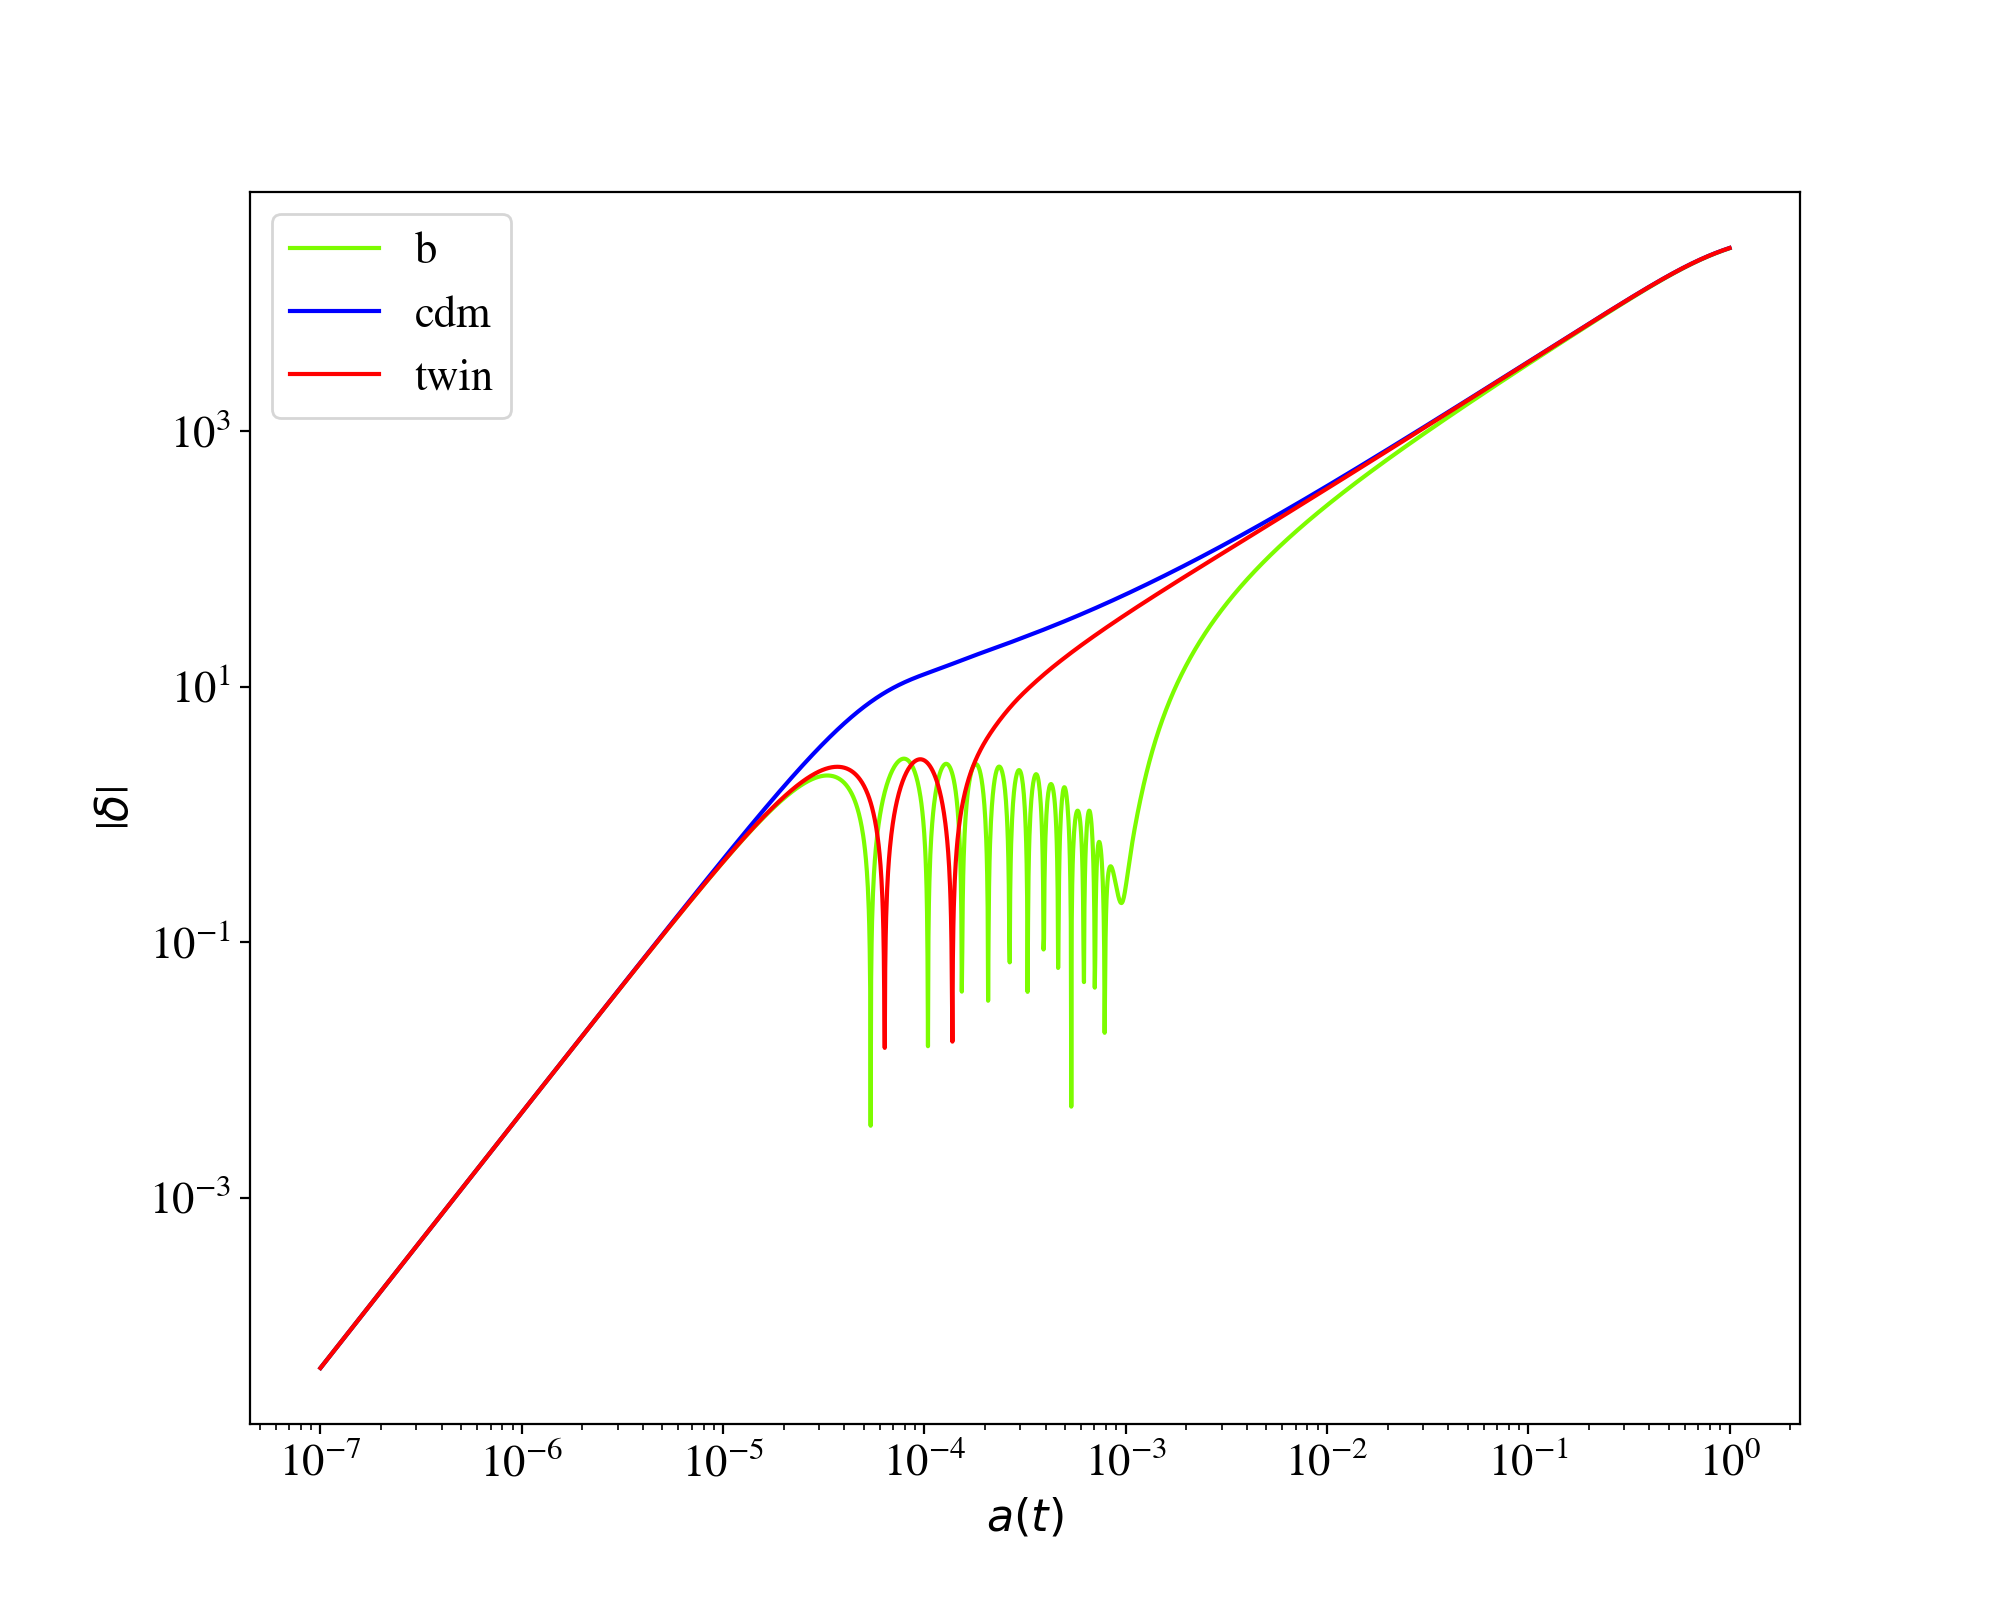

Text(0, 0.5, '|$\\delta$|')

In [6]:

plt.figure()
plt.plot(scale_factors,np.abs(baryon_transfer_z),label="b",color="lawngreen")
plt.plot(scale_factors,np.abs(cdm_transfer_z),label="cdm",color="blue")
plt.plot(scale_factors,np.abs(mdm_transfer_z),label="twin",color="red")
plt.yscale('log')
plt.xscale('log')
plt.legend()
plt.xlabel(r'$a(t)$')
plt.ylabel(r"|$\delta$|")

<IPython.core.display.Javascript object>


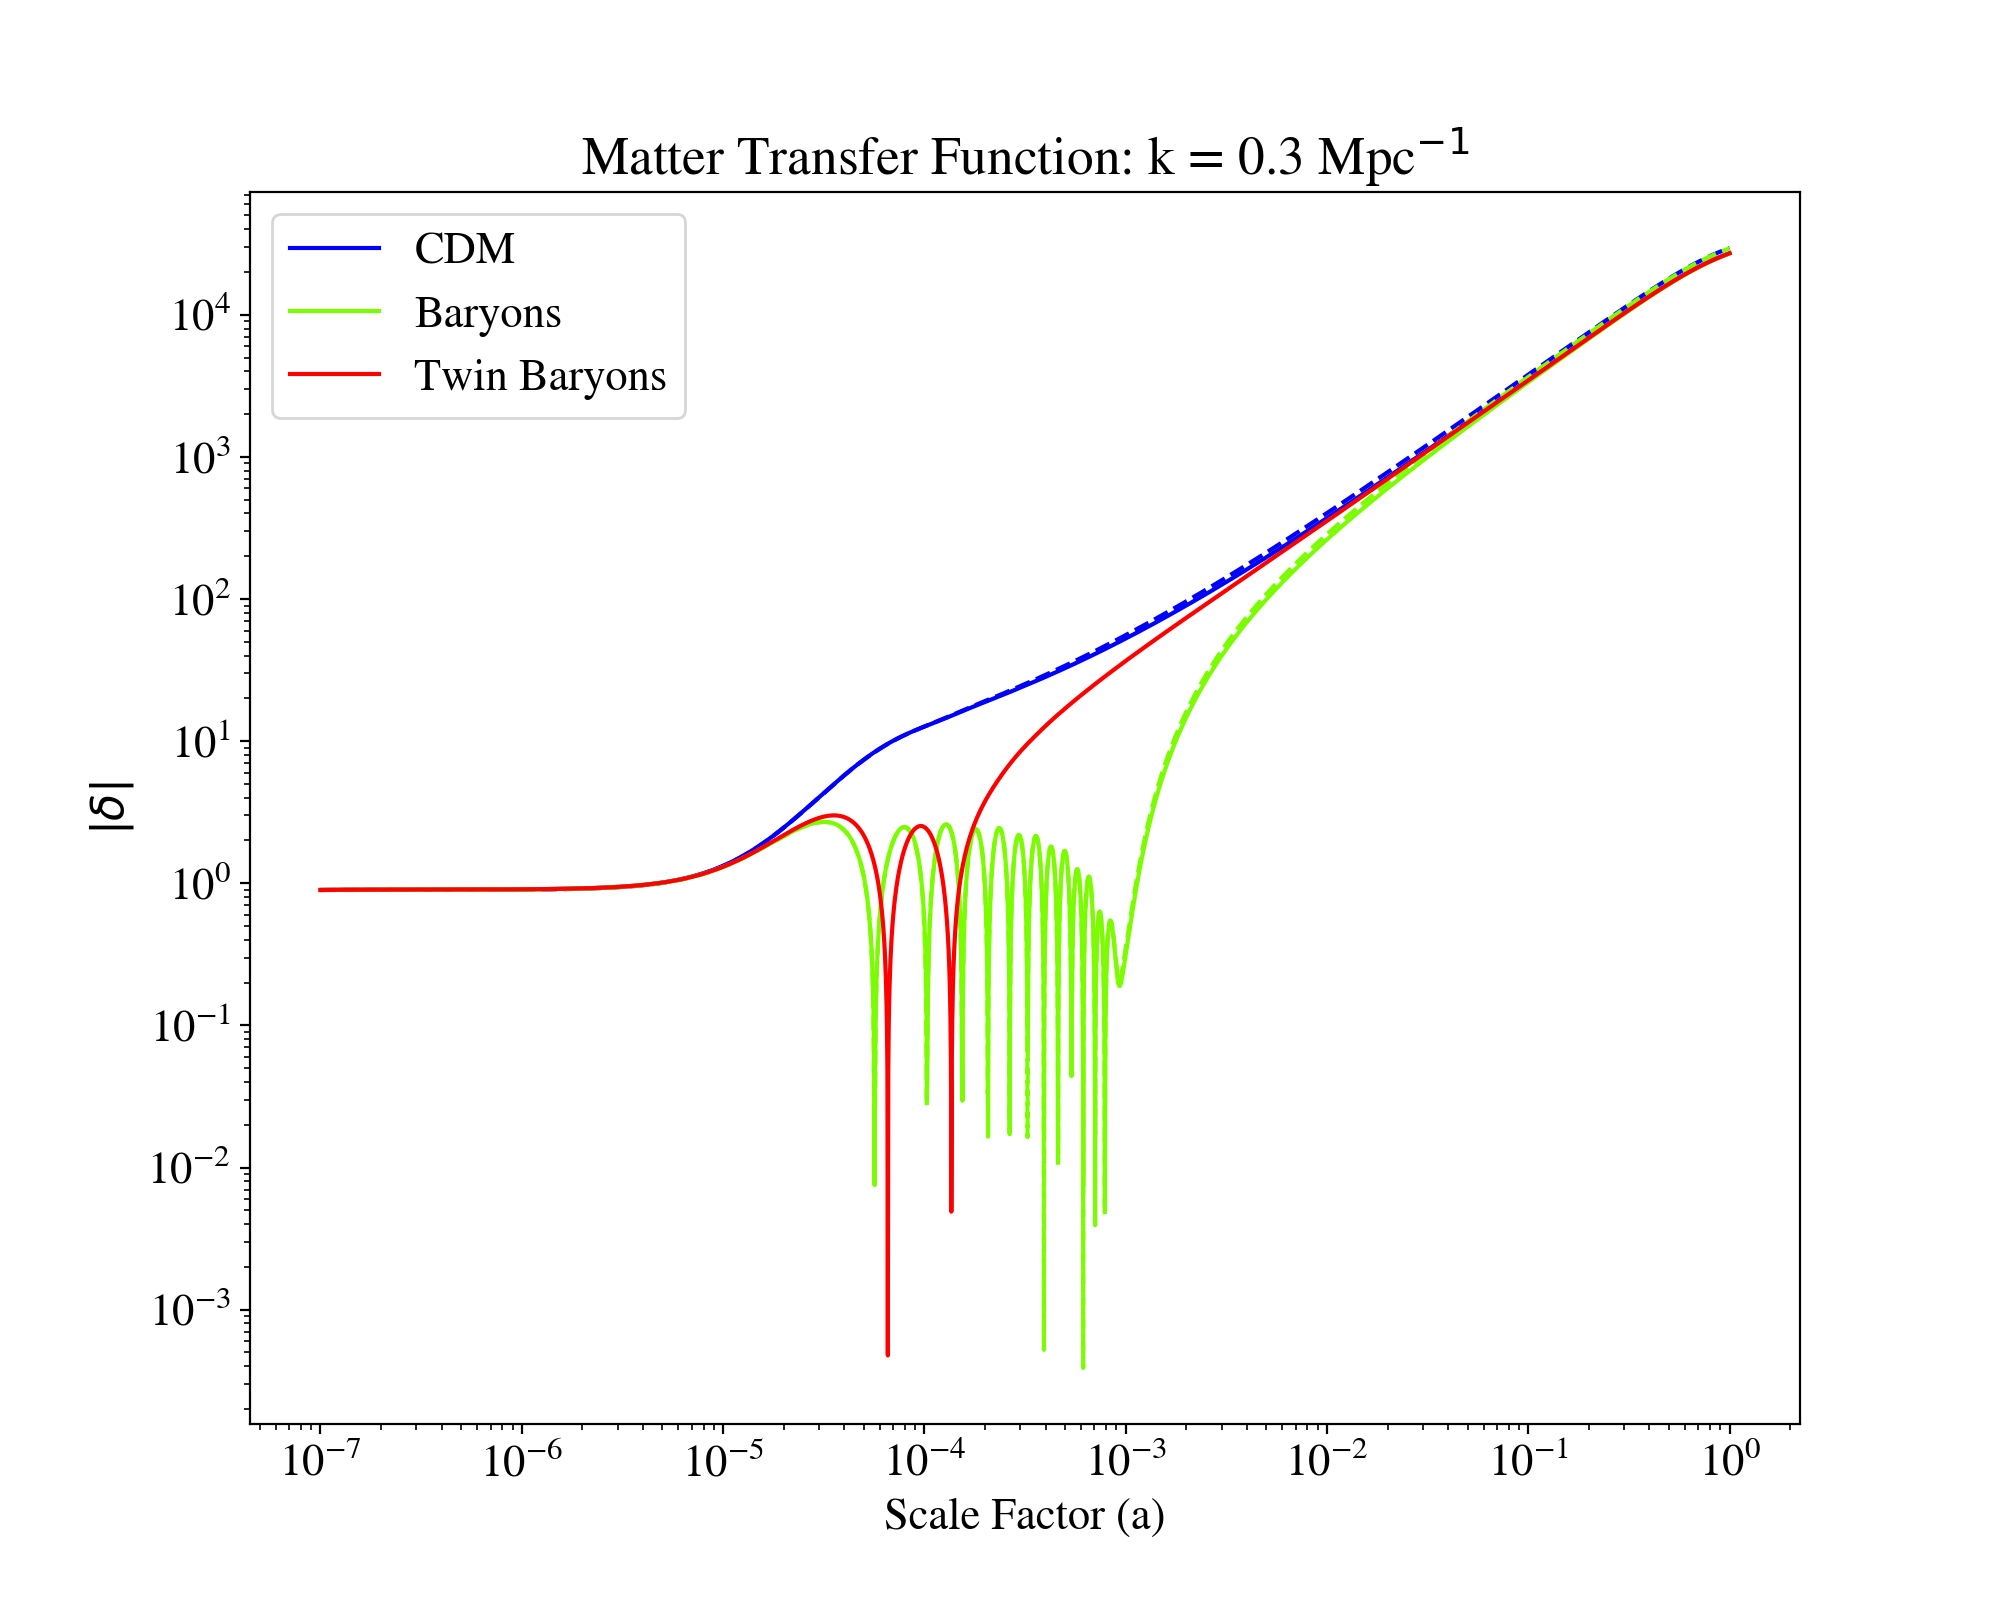

Text(0.5, 0, 'Scale Factor (a)')

In [7]:
#######################
# Plotting the transfer functions for MTH, cdm and baryons
# Use the get_perturbations() method. Get result matching paper. Seems to only do Newtonian gauge. Why??
perturbation = M.get_perturbations()['scalar'][0]
cdm_perturbation = Mcdm.get_perturbations()['scalar'][0]

plt.figure()
plt.title(f"Matter Transfer Function: k = {k} Mpc" + r"$^{-1}$")
#plt.plot(perturbation['a'],np.abs(perturbation['delta_cdm']),color="blue",label="CDM Newtonian gauge")
#plt.plot(scale_factors,np.abs(cdm_transfer_z),label="CDM synchronous gauge",linestyle="--",color="red")
plt.plot(perturbation['a'],np.abs(perturbation['delta_cdm']),color="blue",label="CDM")
plt.plot(cdm_perturbation['a'],np.abs(cdm_perturbation['delta_cdm']),"--",color="blue")
plt.plot(perturbation['a'],np.abs(perturbation['delta_b']),color="lawngreen",label="Baryons")
plt.plot(cdm_perturbation['a'],np.abs(cdm_perturbation['delta_b']),"--",color="lawngreen")
plt.plot(perturbation['a'],np.abs(perturbation['delta_idm_dr']),color="red",label="Twin Baryons")
plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.ylabel(r'$|\delta|$')
plt.xlabel('Scale Factor (a)')

## Looking at Power Spectra

In [85]:
#############################################
#  Setting up standard parameters
#############################################
#
# Cosmological parameters and other CLASS parameters
#

common_settings = {# we need to set the output field to something although
                   # the really releveant outpout here will be set with 'k_output_values'
                   'output':'tCl,pCl,lCl,mPk','lensing':'yes','P_k_max_h/Mpc':1.0,'l_max_scalars':2508,
                   'N_ur': 3.046,
                   'omega_b':2.245082e-02,
                   'omega_cdm':1.194467e-01,
                   'A_s':2.1209941278571784e-09 ,
                   'n_s':9.650600e-01,
                   'tau_reio':5.756324e-02,
                   'k_pivot': 0.05,
                   #'non linear': 'halofit',
                   # TWIN parameters
                   'Delta_N_twin': 0.3,
                   'ratio_vev_twin': 3,
                   'r_all_twin': 1.0e-1, 
                    'Omega_idm_dr': 0,
                    'N_idr': 0,
                    'nindex_idm_dr': 2,
                   # Take fixed value for primordial Helium (instead of automatic BBN adjustment)
                   #'YHe':0.2454,
                   # other options and settings
                   #'compute damping scale':'yes', # needed to output the time of damping scale crossing
                   #'gauge':'newtonian'
                    }

cdm_common_settings = {# we need to set the output field to something although
                   # the really releveant outpout here will be set with 'k_output_values'
                   'output':'tCl,pCl,lCl,mPk','lensing':'yes','P_k_max_h/Mpc':1.0,'l_max_scalars':2508,
                   'N_ur': 3.046,
                   'omega_b':2.245082e-02,
                   'omega_cdm':1.194467e-01,
                   'A_s':2.1209941278571784e-09,
                   'n_s':9.650600e-01,
                   'tau_reio':5.756324e-02,
                   'k_pivot': 0.05,
                   #'non linear': 'halofit',
                   # Take fixed value for primordial Helium (instead of automatic BBN adjustment)
                   #'YHe':0.2454,
                   # other options and settings
                   #'compute damping scale':'yes', # needed to output the time of damping scale crossing
                   #'gauge':'newtonian'
                    }


#
# Different MTH parameter settings (r, Delta N, v_twin/v)
#
params = np.asarray([[0.1,0.3,2],[0.1,0.3,8]])
#params = np.asarray([[0.1,0.3,2],[0.1,0.3,8],[0.1,0.5,3],[0.1,0.1,3],[0.01,0.3,3],[0.2,0.3,3],[0.1,0.3,3],[0.5,0.3,3]])


In [13]:
'''
omega_b = 2.245082e-02
omega_cdm = 1.194467e-01
100*theta_s = 1.041780e+00
ln10^{10}A_s = 3.054470e+00
n_s = 9.650600e-01
tau_reio = 5.756324e-02
N_ur = 3.546
k_pivot =  0.05
Omega_idm_dr =  0
N_idr =  0
r_all_twin =  0
ratio_vev_twin =  0
Delta_N_twin =  0
output =  mPk tCl lCl pCl
P_k_max_h/Mpc =  1.0
lensing =   yes
l_max_scalars =  2508
input_verbose = 1
background_verbose = 1
thermodynamics_verbose = 1
perturbations_verbose = 1
transfer_verbose = 1
primordial_verbose = 1
spectra_verbose = 1
nonlinear_verbose = 1
lensing_verbose = 1
output_verbose = 1
non linear  = halofit
'''

(np.e**3.054470)/(10**(10))

2.1209941278571784e-09

In [86]:

#
# call CLASS for non-MDM LambdaCDM
#
cdm_class_dicts = []
for i,param in enumerate(params):
    Mcdm = Class()
    Mcdm.set(cdm_common_settings)
    Mcdm.set({'r_all_twin':0,'Delta_N_twin':0.0,'ratio_vev_twin':0,'N_ur':3.046+param[1]})
    print(f'N_ur: {3.046 + param[1]}\n')
    #Mcdm.set({'N_ur':3.046+param[1]})
    Mcdm.compute()
    cdm_class_dicts.append(Mcdm)

##############
#    
# call CLASS
#
class_dicts = []


for i,param in enumerate(params):
    M = Class()
    M.set(common_settings)
    M.set({'r_all_twin':param[0],'Delta_N_twin':param[1],'ratio_vev_twin':param[2]})
    print(f'N_ur_eff: {3.046 + param[1]}\n')
    M.compute()
    class_dicts.append(M)


print('done :)')

N_ur: 3.3459999999999996

N_ur: 3.3459999999999996

N_ur_eff: 3.3459999999999996

N_ur_eff: 3.3459999999999996

done :)


In [87]:
###############
# 
# Get matter power spectra
#
def mpk(k_array,class_dict):
    pk = []
    h = class_dict.h()
    for k in k_array:
        pk.append(class_dict.pk(k*h,0.0)* h**3)
    return np.asarray(pk)

kk = np.logspace(-4,np.log10(1.0),1000) # k in h/Mpc

Pks = [mpk(kk,M) for M in class_dicts]
Pks_cdm = [mpk(kk,Mcdm) for Mcdm in cdm_class_dicts]


<IPython.core.display.Javascript object>


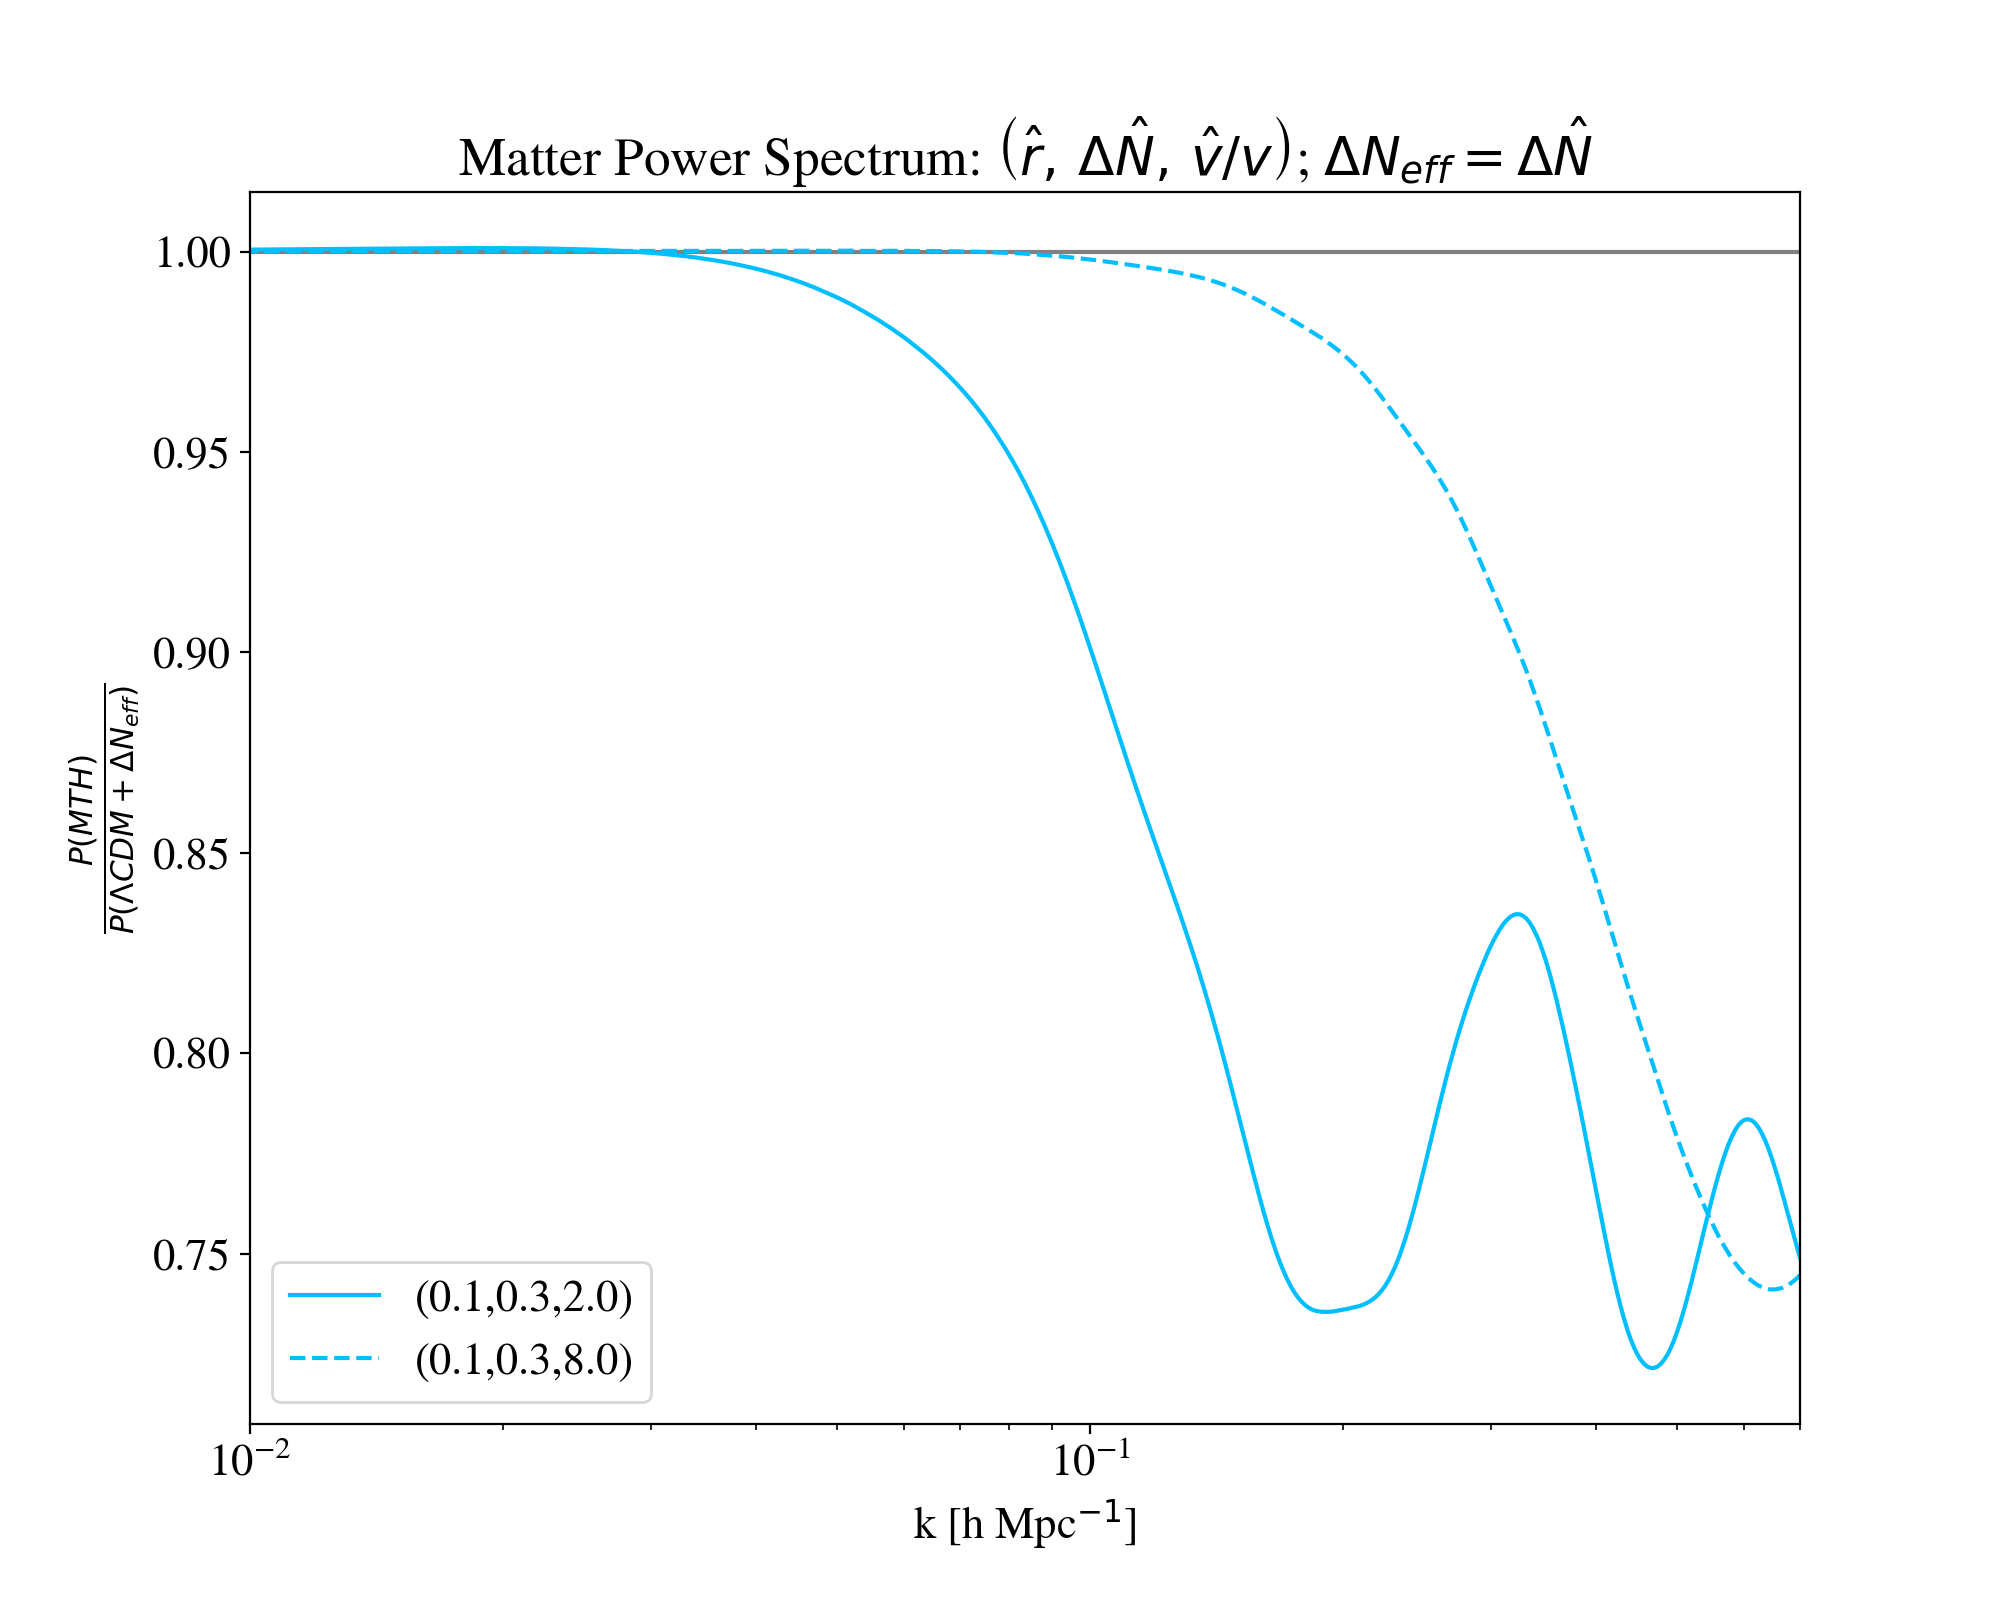

TypeError: argument of type 'NoneType' is not iterable

Exception ignored in: 'classy.Class.__dealloc__'
Traceback (most recent call last):
  File "classy.pyx", line 204, in classy.Class.struct_cleanup
TypeError: argument of type 'NoneType' is not iterable


In [88]:
colors = ['deepskyblue','deepskyblue','purple','purple','orange','orange','red','green']
style = ['','--']

plt.figure()
plt.axhline(1.0,color='gray')
for i,Pk in enumerate(Pks):
    if i < 7:
        plt.plot(kk,Pk/Pks_cdm[i],style[i%2],color=colors[i],label=f"({params[i][0]},{params[i][1]},{params[i][2]})")
        
plt.xscale('log')
plt.xlim([1.0e-2,0.7])
plt.xlabel(r'k [h Mpc$^{-1}$]')
plt.ylabel(r'$\frac{P(MTH)}{P(\Lambda CDM + \Delta N_{eff})}$')
plt.title(r'Matter Power Spectrum: $\left(\hat{r},\, \Delta\hat{N},\, \hat{v}/v\right)$; $\Delta N_{eff} = \Delta \hat{N}$')
plt.legend()

In [44]:
#######################
# CMB Power spectra
#
#
#cls = [M.lensed_cl(2500) for M in class_dicts]
#cdm_cls = [Mcdm.lensed_cl(2500) for Mcdm in cdm_class_dicts]
cls = [M.raw_cl(2500) for M in class_dicts]
cdm_cls = [Mcdm.raw_cl(2500) for Mcdm in cdm_class_dicts]
print("Done :)")

Done :)


<IPython.core.display.Javascript object>


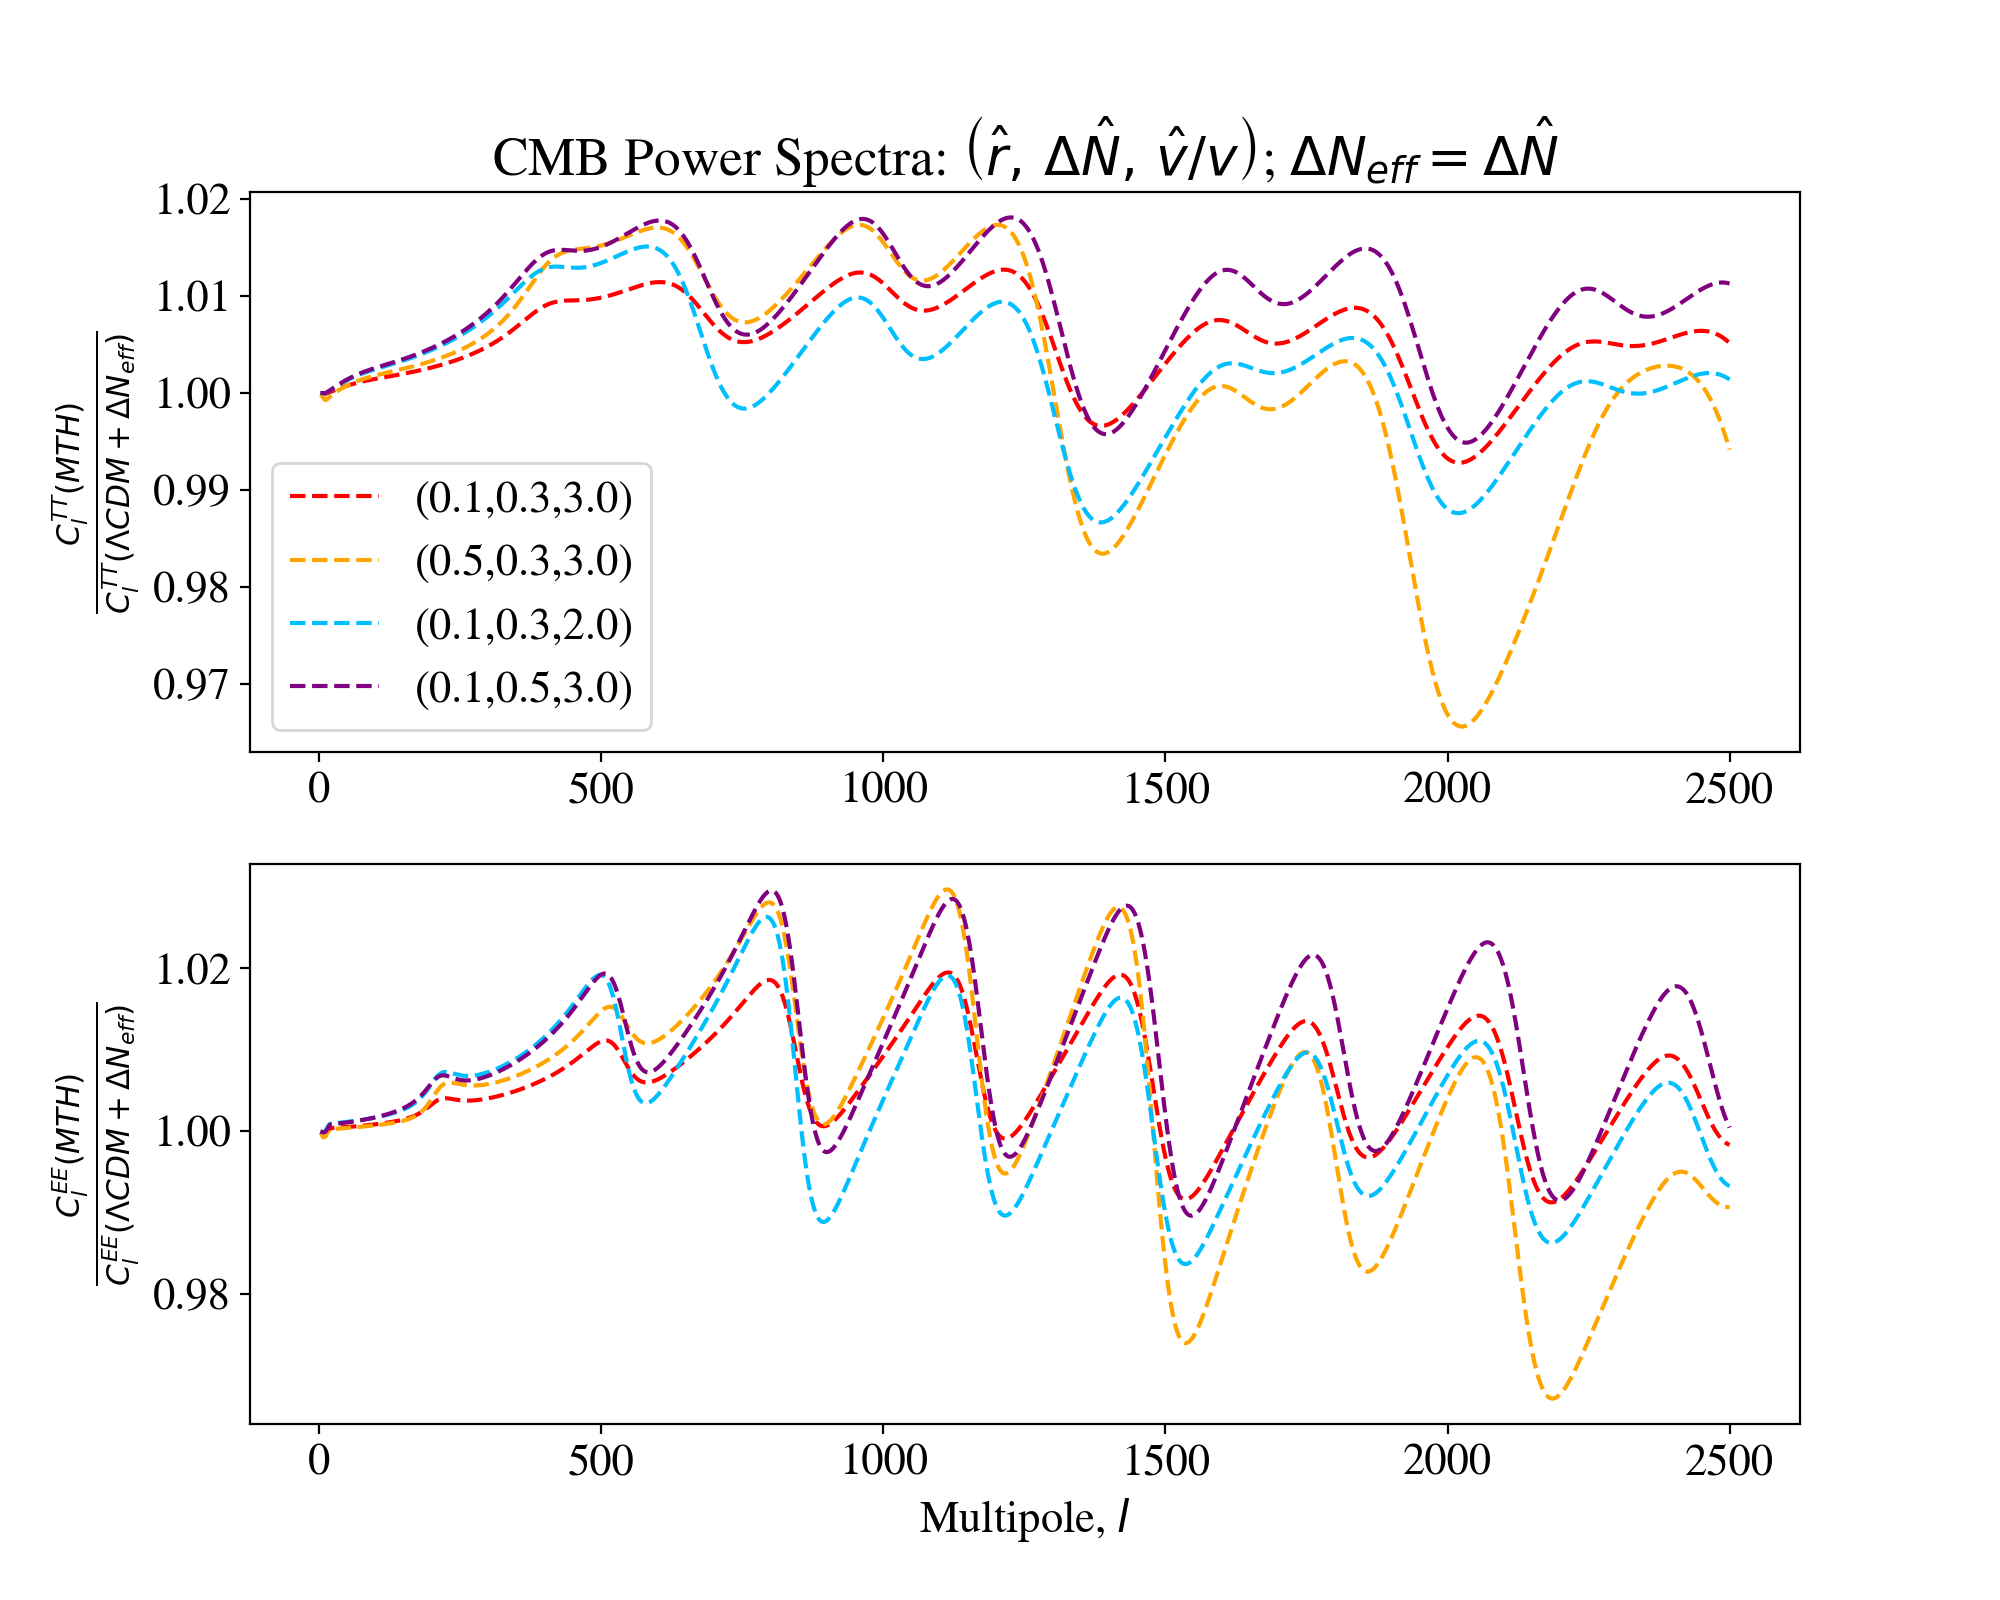

Text(0.5, 0, 'Multipole, $l$')

In [45]:
fig, axs = plt.subplots(2)
indices = [-2,-1,0,2]
colours = ['red','orange','deepskyblue','purple']

for pos,i in enumerate(indices):
    axs[0].plot(cls[i]['ell'][2:],cls[i]['tt'][2:]/cdm_cls[i]['tt'][2:],'--',color = colours[pos],label=f"({params[i][0]},{params[i][1]},{params[i][2]})")
    axs[1].plot(cls[i]['ell'][2:],cls[i]['ee'][2:]/cdm_cls[i]['ee'][2:],'--',color=colours[pos],label=f"({params[i][0]},{params[i][1]},{params[i][2]})")

axs[0].legend()
axs[0].set_title(r"CMB Power Spectra: $\left(\hat{r},\, \Delta\hat{N},\, \hat{v}/v\right)$; $\Delta N_{eff} = \Delta \hat{N}$")
axs[0].set_ylabel(r'$\frac{C^{TT}_l(MTH)}{C^{TT}_l(\Lambda CDM + \Delta N_{eff})}$')
axs[1].set_ylabel(r'$\frac{C^{EE}_l(MTH)}{C^{EE}_l(\Lambda CDM + \Delta N_{eff})}$')
axs[1].set_xlabel(r'Multipole, $l$')